In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import spacy

# Initialize seed
np.random.seed(1)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
# Load dataset
df = pd.read_csv('tripadvisor_lufthansa_reviews.csv', index_col=0)
df.head()

,_id,title,text,rating,reviewer_handle,language,airline_name,flight_date,flight_connection,flight_type,booking_class
0,yLjLWfkb,NaN,Sind am 14.09.2023 von Graz nach Hawaii geflog...,1.0,NaN,NaN,Lufthansa,NaN,NaN,NaN,NaN
1,sssjS6c2,NaN,"Leider lässt sich beobachten, wie nach und nac...",2.0,NaN,NaN,Lufthansa,NaN,NaN,NaN,NaN
2,94ef1WLO,NaN,Bereits zu Zeiten von Corona musste ich einen ...,1.0,NaN,NaN,Lufthansa,NaN,NaN,NaN,NaN
3,zHiYXoJP,NaN,Flug verspätet\nKoffer nicht dabei\nHotline in...,1.0,NaN,NaN,Lufthansa,NaN,NaN,NaN,NaN
4,LkUuygX7,NaN,"Alles Top. Sehr ruhiger Flug, nette Crew, viel...",5.0,NaN,NaN,Lufthansa,NaN,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 995 entries, 0 to 994
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   _id                995 non-null    object 
 1   title              0 non-null      float64
 2   text               995 non-null    object 
 3   rating             995 non-null    float64
 4   reviewer_handle    0 non-null      float64
 5   language           0 non-null      float64
 6   airline_name       995 non-null    object 
 7   flight_date        0 non-null      float64
 8   flight_connection  0 non-null      float64
 9   flight_type        0 non-null      float64
 10  booking_class      0 non-null      float64
dtypes: float64(8), object(3)
memory usage: 93.3+ KB


In [4]:
df[df['rating'] == 5.0]

,_id,title,text,rating,reviewer_handle,language,airline_name,flight_date,flight_connection,flight_type,booking_class
4,LkUuygX7,NaN,"Alles Top. Sehr ruhiger Flug, nette Crew, viel...",5.0,NaN,NaN,Lufthansa,NaN,NaN,NaN,NaN
8,URBtQogZ,NaN,Der Flug war sehr angenehm. Das Personal sehr ...,5.0,NaN,NaN,Lufthansa,NaN,NaN,NaN,NaN
12,tx7mpZYk,NaN,Wir sind mit Kindern gereist und waren begeist...,5.0,NaN,NaN,Lufthansa,NaN,NaN,NaN,NaN
50,GkoF95bm,NaN,"Allen negativen Bewertungen zum Trotz, kann ic...",5.0,NaN,NaN,Lufthansa,NaN,NaN,NaN,NaN
90,UoyU6d9E,NaN,Nachdem man mir bei LH/OS nach über zwanzig Ja...,5.0,NaN,NaN,Lufthansa,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
937,F1hbARBn,NaN,Gebucht für den 03.06.20 - 15.06.2020 /wurde s...,5.0,NaN,NaN,Lufthansa,NaN,NaN,NaN,NaN
942,fi3LOkad,NaN,Auch unser Flug nach Costa Rica wurde stornier...,5.0,NaN,NaN,Lufthansa,NaN,NaN,NaN,NaN
946,7GNh0ZwE,NaN,Die Telefonhotline funktioniert zur Zeit nicht...,5.0,NaN,NaN,Lufthansa,NaN,NaN,NaN,NaN
950,b2dqwSNy,NaN,Meine Buchung ist dank der Expedia untergegang...,5.0,NaN,NaN,Lufthansa,NaN,NaN,NaN,NaN


In [5]:
# Add sentiment label pos, neu, neg
def categorize(rating):

    if rating >= 4.0:
        return 'positive'
    elif rating == 3.0:
        return 'neutral'
    else:
        return 'negative'

<AxesSubplot: >

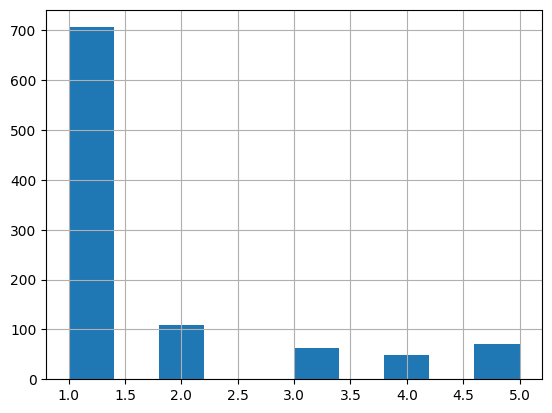

In [6]:
df['rating'].hist()

In [7]:
df['sentiment'] = df['rating'].apply(categorize)

<AxesSubplot: >

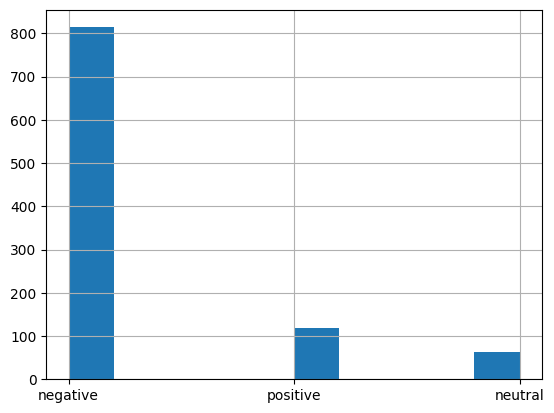

In [8]:
df['sentiment'].hist()

In [9]:
# Sentiment to target number
target_map = {'positive':1, 'negative':0, 'neutral':2}
df['target'] = df['sentiment'].map(target_map)

In [30]:
# Initialize german language model
##download and install the model
##pip install spacy
##pip install -U pip setuptools wheel
##pip install -U spacy
##python -m spacy download en_core_web_sm
nlp = spacy.load("de_core_news_sm")

In [11]:
# Preprocessing

def lower(review):
    return review.lower()

def remove_stopwords(review):
    
    doc = nlp(review)
    filtered_tokens = [token.text for token in doc if not token.is_stop]
    review = ' '.join(filtered_tokens)
    
    return review

def remove_punct(review):
    
    pattern = r'[^a-zA-ZäöüÄÖÜß\s]'
    review = re.sub(pattern, '', review)
    return review

def remove_trailing_newlines(review):

    pattern = r'\n+$'
    review = re.sub(pattern, '', review)
    return review

def lemmatize(review):
    
    doc = nlp(review)
    lemmatized_tokens = [token.lemma_ for token in doc]
    lemmatized_text = ' '.join(lemmatized_tokens)
    
    return lemmatized_text

def replace_spaces(review):
    review = re.sub(r'\s+', ' ', review)
    return review
    

In [31]:
# Preprocessing

df['text'] = df['text'].apply(lower)
df['text'] = df['text'].apply(remove_stopwords)
df['text'] = df['text'].apply(remove_punct)
df['text'] = df['text'].apply(remove_trailing_newlines)
df['text'] = df['text'].apply(lemmatize)
df['text'] = df['text'].apply(replace_spaces)

In [13]:
df.head()

,_id,title,text,rating,reviewer_handle,language,airline_name,flight_date,flight_connection,flight_type,booking_class,sentiment,target
0,yLjLWfkb,NaN,sind am 14.09.2023 von graz nach hawaii geflog...,1.0,NaN,NaN,Lufthansa,NaN,NaN,NaN,NaN,negative,0
1,sssjS6c2,NaN,"leider lässt sich beobachten, wie nach und nac...",2.0,NaN,NaN,Lufthansa,NaN,NaN,NaN,NaN,negative,0
2,94ef1WLO,NaN,bereits zu zeiten von corona musste ich einen ...,1.0,NaN,NaN,Lufthansa,NaN,NaN,NaN,NaN,negative,0
3,zHiYXoJP,NaN,flug verspätet\nkoffer nicht dabei\nhotline in...,1.0,NaN,NaN,Lufthansa,NaN,NaN,NaN,NaN,negative,0
4,LkUuygX7,NaN,"alles top. sehr ruhiger flug, nette crew, viel...",5.0,NaN,NaN,Lufthansa,NaN,NaN,NaN,NaN,positive,1


In [15]:
# Training

# Train-Test split
df_train, df_test =train_test_split(df)

In [16]:
df_train.head()

,_id,title,text,rating,reviewer_handle,language,airline_name,flight_date,flight_connection,flight_type,booking_class,sentiment,target
909,PgHFKo4v,NaN,anfang juli wurde unser flug von lufthansa sto...,1.0,NaN,NaN,Lufthansa,NaN,NaN,NaN,NaN,negative,0
298,f8u0VDI2,NaN,im prinzip funktioniert die abwicklung gut und...,2.0,NaN,NaN,Lufthansa,NaN,NaN,NaN,NaN,negative,0
160,Y7nH9xIW,NaN,wer in zeiten des krieges nach tokio und zurüc...,5.0,NaN,NaN,Lufthansa,NaN,NaN,NaN,NaN,positive,1
268,3MnXmm2a,NaN,abgesehen davon das ich meine verloren gegange...,1.0,NaN,NaN,Lufthansa,NaN,NaN,NaN,NaN,negative,0
776,dL977ZgZ,NaN,lufthansa hat sich spontan entschieden unseren...,1.0,NaN,NaN,Lufthansa,NaN,NaN,NaN,NaN,negative,0


In [18]:
vectorizer = TfidfVectorizer(max_features=50)

In [19]:
X_train = vectorizer.fit_transform(df_train['text'])

In [20]:
X_train

<746x50 sparse matrix of type '<class 'numpy.float64'>'
	with 15880 stored elements in Compressed Sparse Row format>

In [21]:
X_test = vectorizer.transform(df_test['text'])

In [22]:
Y_train = df_train['target']
Y_test = df_test['target']

In [23]:
model = LogisticRegression(max_iter=500)
model.fit(X_train, Y_train)
print("Train Acc:", model.score(X_train, Y_train))
print("Test Acc:", model.score(X_test, Y_test))

Train Acc: 0.8485254691689008
Test Acc: 0.8273092369477911


In [24]:
Pr_train = model.predict_proba(X_train)
Pr_test = model.predict_proba(X_test)
print("Train AUC-ROC:", roc_auc_score(Y_train, Pr_train, multi_class='ovo'))
print("Test AUC-ROC:", roc_auc_score(Y_test, Pr_test, multi_class='ovo'))

Train AUC-ROC: 0.8301354582236935
Test AUC-ROC: 0.8050458448382324


In [25]:
P_train = model.predict(X_train)
P_test = model.predict(X_test)

In [26]:
cm = confusion_matrix(Y_train, P_train, normalize='true')
cm

array([[0.99188312, 0.00811688, 0.        ],
       [0.75294118, 0.24705882, 0.        ],
       [0.93333333, 0.04444444, 0.02222222]])

In [83]:
# Heavily biased towards negative sentiments
# Does not classify neutral comments well due to negative sentiment neutral comments
# Badly classifies positive comments due to underrepresentation of positive classes